# Прогнозирование ухода клиентов сети фитнес клубов.

Цель: Построить модель прогнозирования ухода клиентов сети фитнес клубов.

Описание данных.

Данные пользователя за предыдущий до проверки факта оттока месяц:
- 'Churn' — факт оттока в текущем месяце;
- 'gender' — пол
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
- 'Phone' — наличие контактного телефона
- 'Age' — возраст
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)
- 'Group_visits' — факт посещения групповых занятий
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# отображать до 150 символов в ячейках таблицы:
pd.set_option('display.max_colwidth',150)

# Отображать все столбцы в таблицах:
pd.set_option('display.max_columns', None)

# Библиотека разделения выборки:
from sklearn.model_selection import train_test_split

# Импорт алгоритма - логистическая регрессия:
from sklearn.linear_model import LogisticRegression

# Импорт алгоритмов - случайный лес и градиентный бустинг:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Метрики моделей:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

# Библиотека стандартизации:
from sklearn.preprocessing import StandardScaler

# Импорте классов моделей кластеризации linkage() и dendrogram() из модуля для иерархической кластеризации hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage

# Импорт алгоритма KMeans:
from sklearn.cluster import KMeans

# Метрика силуэта:
from sklearn.metrics import silhouette_score

## Просмотр и предобработка данных

In [4]:
# Просмотр данных:
df = pd.read_csv('gym_churn.csv')
df.info()
display(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.406023,12.0,8,2.284497,2.349070,0
3996,0,1,0,0,1,1,1,29,68.883764,1.0,1,1.277168,0.292859,1
3997,1,1,1,1,1,12,0,28,78.250542,11.0,2,2.786146,2.831439,0
3998,0,1,1,1,1,6,0,32,61.912657,5.0,3,1.630108,1.596237,0


In [5]:
# Переведем названия столбцов в нижний регистр:
df.columns = [x.lower() for x in df.columns]
display(df.head(2))

# Изменение типа данных на int:
df['month_to_end_contract'] = df['month_to_end_contract'].astype('int')

# Округлим данные в столбцах до двух знаков после запятой:
df['avg_additional_charges_total'] = df['avg_additional_charges_total'].round(2)
df['avg_class_frequency_total'] = round(df['avg_class_frequency_total'], 2)
df['avg_class_frequency_current_month'] = df['avg_class_frequency_current_month'].round(2)
display(df.head(2))

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.23,5,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12,7,1.92,1.91,0


In [6]:
# Посмотрим на распределение данных в столбцах:
for col in df.columns:
    display("Столбец: " + str(col))
    display(df[col].value_counts().reset_index().sort_values(by='index'))

'Столбец: gender'

,index,gender
1,0,1959
0,1,2041


'Столбец: near_location'

,index,near_location
1,0,619
0,1,3381


'Столбец: partner'

,index,partner
0,0,2053
1,1,1947


'Столбец: promo_friends'

,index,promo_friends
0,0,2766
1,1,1234


'Столбец: phone'

,index,phone
1,0,386
0,1,3614


'Столбец: contract_period'

,index,contract_period
0,1,2207
2,6,833
1,12,960


'Столбец: group_visits'

,index,group_visits
0,0,2351
1,1,1649


'Столбец: age'

,index,age
21,18,2
20,19,2
17,20,14
16,21,24
14,22,33
12,23,82
10,24,148
8,25,231
6,26,300
4,27,378


'Столбец: avg_additional_charges_total'

,index,avg_additional_charges_total
586,0.15,1
1210,0.17,1
1525,0.25,1
3605,0.33,1
1100,0.36,1
...,...,...
708,488.71,1
3237,496.17,1
1001,515.39,1
1412,534.26,1


'Столбец: month_to_end_contract'

,index,month_to_end_contract
0,1,2207
11,2,14
10,3,23
7,4,58
4,5,130
1,6,645
9,7,25
8,8,38
6,9,73
5,10,82


'Столбец: lifetime'

,index,lifetime
3,0,487
0,1,843
1,2,610
2,3,490
4,4,383
5,5,273
6,6,220
7,7,167
8,8,111
9,9,100


'Столбец: avg_class_frequency_total'

,index,avg_class_frequency_total
0,0.00,89
330,0.01,4
387,0.02,2
348,0.03,3
354,0.04,3
...,...,...
413,5.08,1
425,5.14,1
408,5.41,1
441,5.42,1


'Столбец: avg_class_frequency_current_month'

,index,avg_class_frequency_current_month
0,0.00,184
133,0.01,12
399,0.02,2
316,0.03,5
327,0.04,5
...,...,...
416,4.98,1
419,5.02,1
424,5.37,1
444,5.46,1


'Столбец: churn'

,index,churn
0,0,2939
1,1,1061


In [7]:
# Проверим дубликаты:
duplicated_row = df.duplicated().sum()
display(duplicated_row)

0

<div class="alert alert-info"> Вывод: Пропусков, ошибок, аномальных значений в данных нет, значения соответствуют наименованию столбцов. Привели имена столбцов к нижнему регистру, округлили значения в некоторых столбцах, и исправили тип данных в столбце - 'month_to_end_contract' в тип int. Дубликатов  не выявленно.

## Исследовательский анализ данных (EDA)

### Посмотрим на датасет, описательные статистики:

In [8]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943730,4.322750,3.724750,1.879035,1.76707,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355654,4.191297,3.749267,0.972305,1.05290,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.150000,1.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.865000,1.000000,1.000000,1.180000,0.96000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220000,1.000000,3.000000,1.830000,1.72000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.947500,6.000000,5.000000,2.540000,2.51000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590000,12.000000,31.000000,6.020000,6.15000,1.000000


<div class="alert alert-info"> Портрет среднестатистического клиента:
    
Фитнес-центр посещают мужчины и женщины в равной степени. Среднестатистический клиент - проживает или работает в районе место нахождения фитнес-центра. Первоначально пришел сам(без промокода). Оставил контактный телефон. Имеет действующий абонемент на 4,7 месяца. Не посещает групповые занятия. Возрас - 29. Приносит суммарную выручку от других услуг фитнес-центра в размере - 147. Имеет срок окончания действующего абонемента 4,3 мес. И время с момента первого обращения в фитнес-центр - 3,7 мес. Средняя частота посещений в неделю за все время с начала действия абонемента составляет - 1,9 раза. Средняя частота посещений в неделю за предыдущий месяц - 1,76. Склонен к уходу.

### Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [9]:
# Вычислим средние значения
churn = df.groupby('churn').mean().reset_index()

# Вычислим во сколько раз ср.значения признаков оставшихся клиентов клиентов выше ср.значений клиентов, попавших в отток:
churn.loc['diff'] = churn.loc[0] / churn.loc[1]
display(churn)

,churn,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0.0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445716,5.283089,4.711807,2.024917,2.027873
1,1.0,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082903,1.662582,0.990575,1.474939,1.044637
diff,0.0,0.998431,1.136619,1.503398,1.923520,1.000872,3.324848,1.727768,1.110668,1.376796,3.177641,4.756638,1.372882,1.941223


<div class="alert alert-info"> Вывод: Средние значения признаков клиентов, которые остаются от 1.4 до 4.7 раз больше средних значений клиентов, которые попадают в отток.

### Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

In [10]:
# Создадим датафрейм - наименование столбцов - описание столбцов (понадобиться для автоматизации постороения графиков
#и подписей к ним)
colmns = pd.DataFrame({'eng':['gender',
                              'near_location',
                              'partner',
                              'promo_friends',
                              'phone',
                              'contract_period',
                              'group_visits',
                              'age',
                              'avg_additional_charges_total',
                              'month_to_end_contract',
                              'lifetime',
                              'avg_class_frequency_total',
                              'avg_class_frequency_current_month'],
                      'rus':
                      ['Пол',
                       'Проживание или работа в районе, где находится фитнес-центр',
                       'Сотрудник компании-партнёра клуба',
                       'Факт первоначальной записи в рамках акции «приведи друга»',
                       'Наличие контактного телефона',
                       'Длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)',
                       'Факт посещения групповых занятий',
                       'Возраст',
                       'Суммарная выручка от других услуг фитнес-центра',
                       'Срок до окончания текущего действующего абонемента (в месяцах)',
                       'Время с момента первого обращения в фитнес-центр (в месяцах)',
                       'Средняя частота посещений в неделю за все время с начала действия абонемента',
                       'Средняя частота посещений в неделю за предыдущий месяц']})

# Непрерывные признаки:
colmns_cont = pd.DataFrame({'eng':['age',
                              'avg_additional_charges_total',
                              'month_to_end_contract',
                              'lifetime',
                              'avg_class_frequency_total',
                              'avg_class_frequency_current_month'],
                      'rus':
                      ['Возраст',
                       'Суммарная выручка от других услуг фитнес-центра',
                       'Срок до окончания текущего действующего абонемента (в месяцах)',
                       'Время с момента первого обращения в фитнес-центр (в месяцах)',
                       'Средняя частота посещений в неделю за все время с начала действия абонемента',
                       'Средняя частота посещений в неделю за предыдущий месяц']})
# Дискретные признаки:
colmns_discr = pd.DataFrame({'eng':['gender',
                              'near_location',
                              'partner',
                              'promo_friends',
                              'phone',
                              'contract_period',
                              'group_visits'],
                      'rus':
                      ['Пол',
                       'Проживание или работа в районе, где находится фитнес-центр',
                       'Сотрудник компании-партнёра клуба',
                       'Факт первоначальной записи в рамках акции «приведи друга»',
                       'Наличие контактного телефона',
                       'Длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)',
                       'Факт посещения групповых занятий']})


display(colmns)

,eng,rus
0,gender,Пол
1,near_location,"Проживание или работа в районе, где находится фитнес-центр"
2,partner,Сотрудник компании-партнёра клуба
3,promo_friends,Факт первоначальной записи в рамках акции «приведи друга»
4,phone,Наличие контактного телефона
5,contract_period,"Длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)"
6,group_visits,Факт посещения групповых занятий
7,age,Возраст
8,avg_additional_charges_total,Суммарная выручка от других услуг фитнес-центра
9,month_to_end_contract,Срок до окончания текущего действующего абонемента (в месяцах)


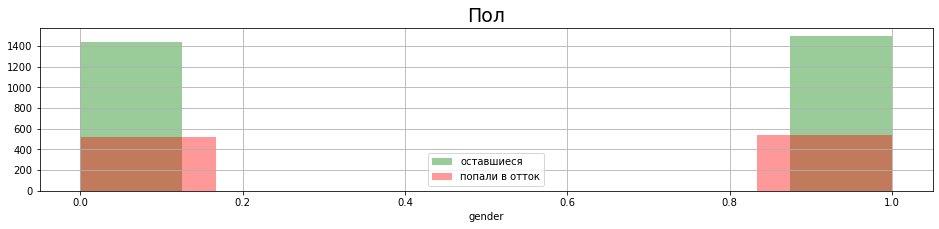

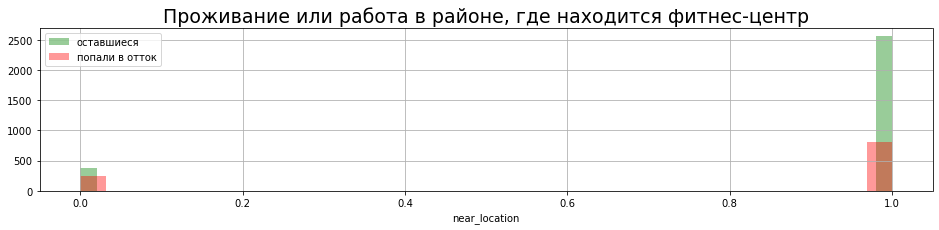

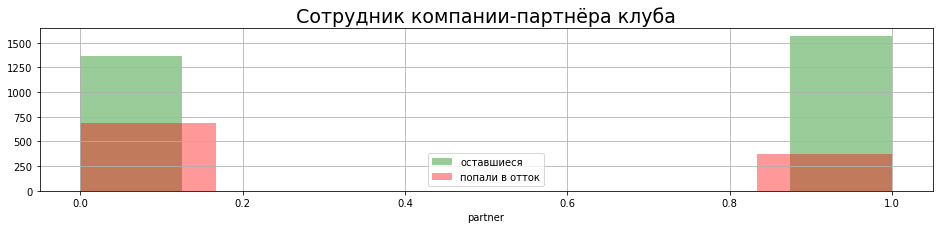

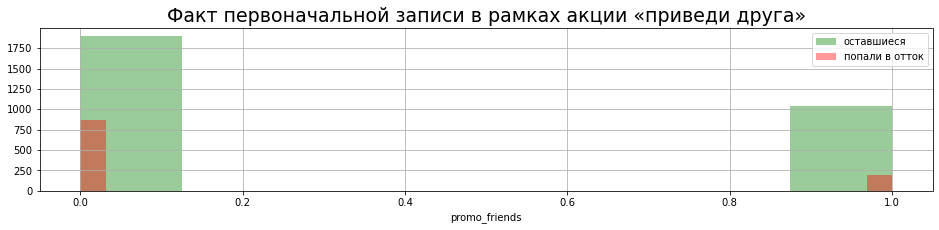

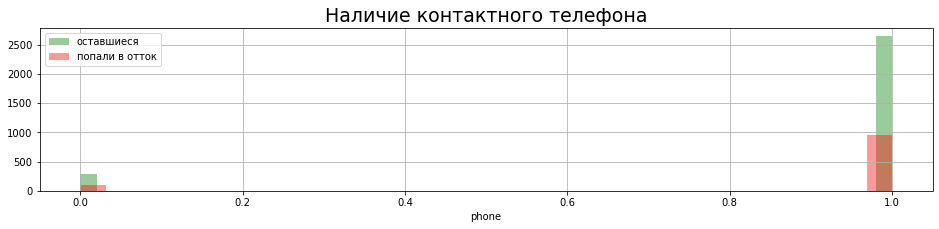

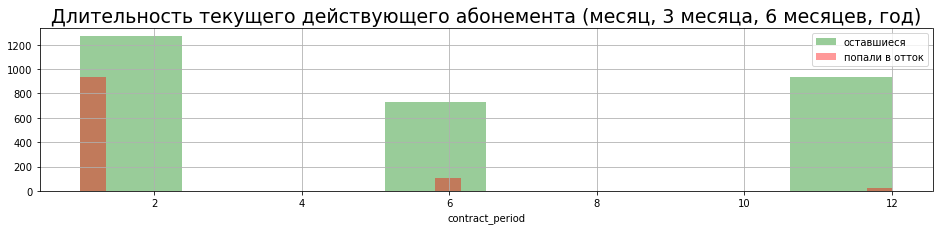

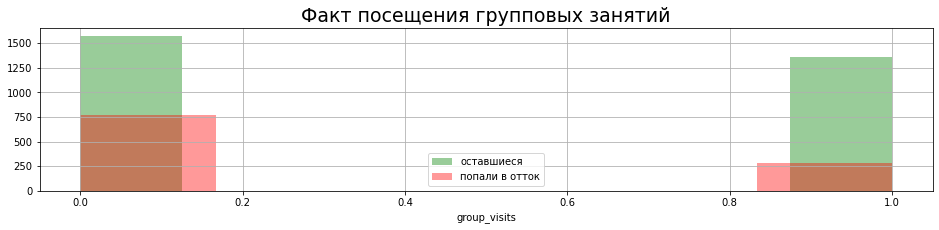

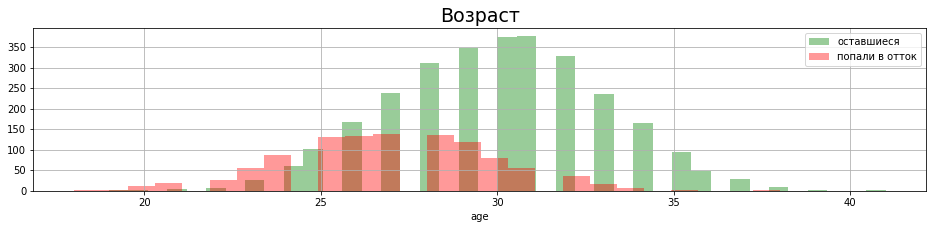

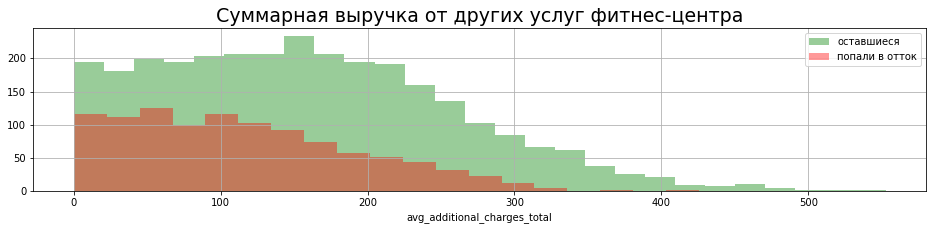

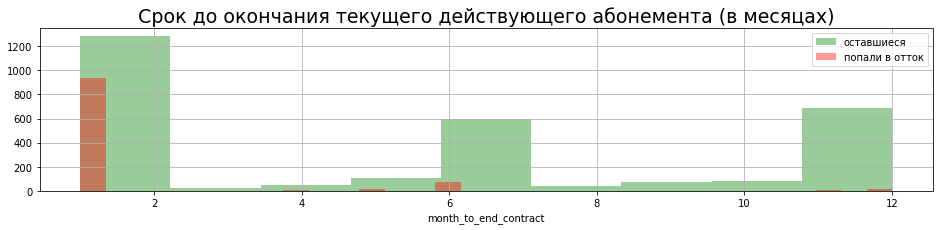

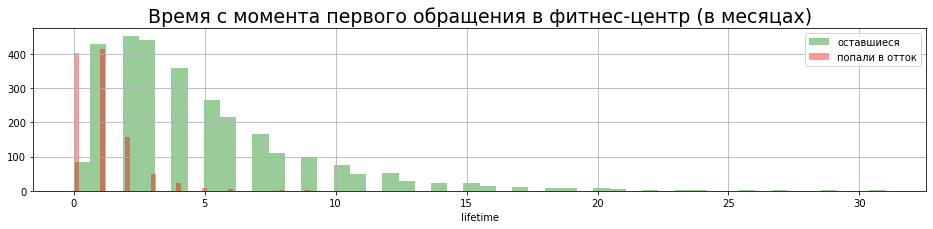

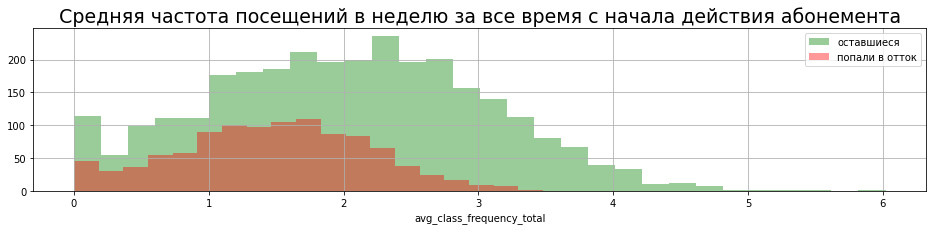

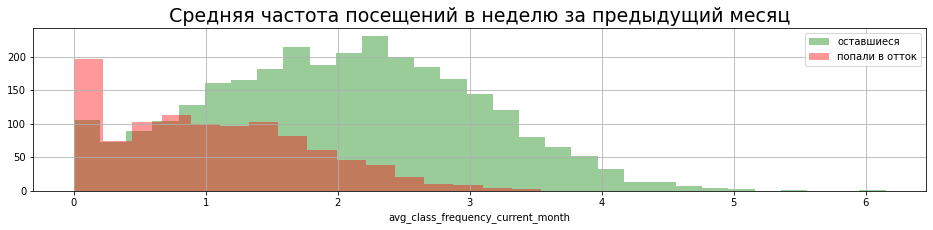

In [11]:
# Построим гистограммы признаков с разделением попавших в отток и оставшихся:
i = 1
for col, name in zip(colmns['eng'], colmns['rus']):
    plt.figure(figsize=(16,100))
    plt.subplot(28, 1, i)   
    
    # С помощью seaborn.displot:
    sns.distplot(df[df['churn']==0][col], color="green", label='оставшиеся', hist=True, kde=False)
    sns.distplot(df[df['churn']==1][col], color="red", label='попали в отток', hist=True, kde=False)
    
    # С помощью .plot.hist():
    #df[df['churn']==0][col].plot.hist(bins=15, color='green')
    #df[df['churn']==1][col].plot.hist(bins=15, color='red')
    
    plt.title(name, fontsize=19)
    plt.legend()
    plt.xlabel(col)
    plt.grid(True)
    i = i+1
    plt.show()

### Построим матрицу корреляций и отобразим её.

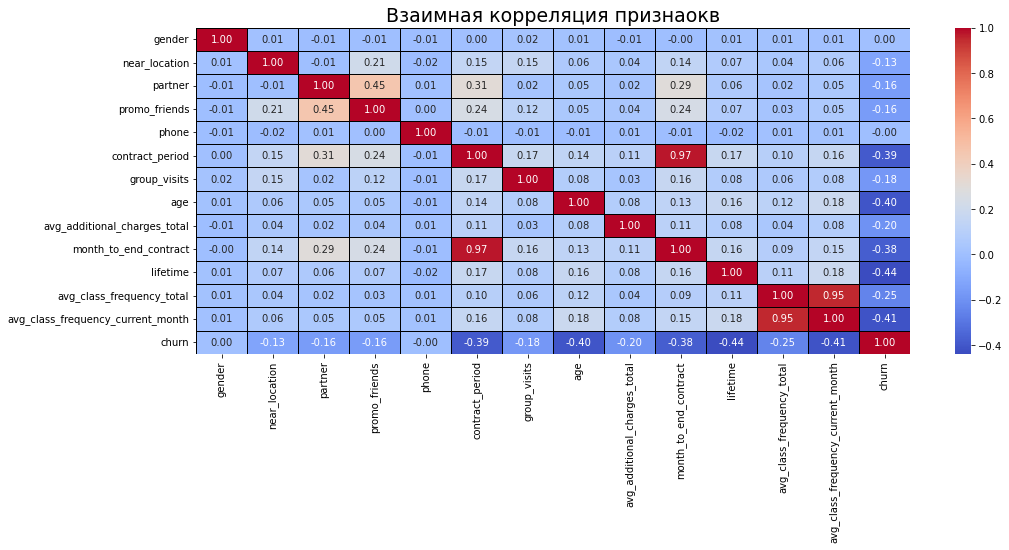

In [12]:
# Построим матрицу корреляции признаков:
df_corr = df.corr()
with plt.style.context('seaborn-pastel'):
    plt.figure(figsize=(16,6))
    plt.title('Взаимная корреляция признаокв', fontsize=19)
    sns.heatmap(df_corr, annot=True, fmt='.2f', linewidths=0.7, linecolor='black', cmap= 'coolwarm')
    plt.show()

<div class="alert alert-info">Вывод: На тепловой карте заметна очень сильная корреляция двух признаков: 'contract_period' и 'month_to_end_contract', коэффициент корреляции = 0,97. C Целевой переменной 'churn' не значительно коррелируют четыре признака - 'Avg_class_frequency_current_month', 'lifetime', 'age', 'contract_period', коэффициент корреляции для всех около 0.4.

## Построим модель прогнозирования оттока клиентов

### Построим модель бинарной классификации пользователей, где целевой признак — факт оттока пользователя в следующем месяце:

#### Разделим данные на обучающую и валидационную выборку функцией train_test_split().

In [13]:
# Отделим признаки от целевой переменной:
X = df.drop('churn', axis = 1) 
y = df['churn']

display(X.head(1))
display(y.head(3))

# Разделяем данные на обучающую и валидационную выборки в долях 0.8 на 0.2 соответственно:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 0)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,1,1,1,1,0,6,1,29,14.23,5,3,0.02,0.0


0    0
1    0
2    0
Name: churn, dtype: int64

In [14]:
# Стандартизируем данные по всему набору признаков:
scaler = StandardScaler()

# Обучим и стандартизируем обучающую и валидационную выборки:
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.fit_transform(X_test)

#### Обучим модель на train-выборке двумя способами:
- логистической регрессией
- случайным лесом

In [16]:
# Задаем алгоритм модели - логистическая регрессия:
# Присвоим модели алгоритм - LogisticRegression():
model = LogisticRegression(random_state = 0)

# Обучаем модель:
model.fit(X_train_st, y_train)

# Рассчитываем прогноз целевой переменной:
log_regress_prediction = model.predict(X_test_st)

#display(log_regress_prediction)

In [17]:
# Создадим датафрейм с признаками и их весами

coef = model.coef_.flatten().round(3)
display(coef)
features = pd.DataFrame({'feature':X_train.columns, 'coeff':coef})
display(features)

array([-0.005, -0.053, -0.067, -0.143, -0.023, -0.708, -0.402, -1.167,
       -0.572, -0.627, -3.581,  3.112, -4.214])

,feature,coeff
0,gender,-0.005
1,near_location,-0.053
2,partner,-0.067
3,promo_friends,-0.143
4,phone,-0.023
5,contract_period,-0.708
6,group_visits,-0.402
7,age,-1.167
8,avg_additional_charges_total,-0.572
9,month_to_end_contract,-0.627


In [18]:
# Задаем алгоритм модели - случайный лес:

# Параметры:
# число деревьев, на основании которых строиться лес - n_estimators
# глубина дерева - max_depth
# размер подвыборки признаков - max_features
# минимальное количество объектов в узле - min_samples_leaf

# Присвоим модели алгоритм - RandomForestClassifier(), т.к. решаем задачу классификации:
rand_forest_model = RandomForestClassifier(n_estimators = 100, random_state = 0)

# Обучаем модель:
rand_forest_model.fit(X_train_st, y_train)

# Рассчитываем прогноз целевой переменной:
rand_forest_prediction = rand_forest_model.predict(X_test_st)

# Вычисление вероятности определения оттока пользователей (0 или 1)
rand_forest_probabilities = rand_forest_model.predict_proba(X_test_st)[:,1]

#display(rand_forest_prediction)
#display(rand_forest_probabilities)

#### Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравним по ним модели. Определим модель, которая показала себя лучше на основании метрик.

In [19]:
# Метрики accuracy, precision и recall для модели - логистической регрессии:
print("Метрики для модели - логистической регрессии:")
print('\tAccuracy: {:.2f}'.format(accuracy_score(y_test, log_regress_prediction)))
print('\tPrecision: {:.2f}'.format(precision_score(y_test, log_regress_prediction)))
print('\tRecall: {:.2f}'.format(recall_score(y_test, log_regress_prediction)))
print()

# Метрики accuracy, precision и recall для модели - случайный лес:
print("Метрики для модели - случайный лес:")
print('\tAccuracy: {:.2f}'.format(accuracy_score(y_test, rand_forest_prediction)))
print('\tPrecision: {:.2f}'.format(precision_score(y_test, rand_forest_prediction)))
print('\tRecall: {:.2f}'.format(recall_score(y_test, rand_forest_prediction)))

Метрики для модели - логистической регрессии:
	Accuracy: 0.93
	Precision: 0.89
	Recall: 0.85

Метрики для модели - случайный лес:
	Accuracy: 0.93
	Precision: 0.88
	Recall: 0.83


<div class="alert alert-info"> Вывод: Метрики - доля правильных ответов (accuracy), точность (precision) и полнота (recall) для модели логистической регрессии не много выше чем для модели - случайный лес, 0.93, 0.89, 0.85 против 0,93, 0.88, 0.83 соответственно.

## Сделаем кластеризацию пользователей.

In [20]:
# Cтандартизируем данные всего датафрейма без целевой пременной (ранее мы сделали выборку - X = df.drop('churn', axis = 1)):
sc = StandardScaler()
x_sc = sc.fit_transform(X)

#### Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму.  На основании полученного графика предположим, какое количество кластеров можно выделить.

array([[9.70000000e+01, 3.22200000e+03, 1.01215880e-01, 2.00000000e+00],
       [2.61000000e+02, 3.17900000e+03, 1.16182236e-01, 2.00000000e+00],
       [8.90000000e+02, 1.75000000e+03, 1.27567806e-01, 2.00000000e+00],
       ...,
       [7.98700000e+03, 7.99500000e+03, 8.35989427e+01, 2.60900000e+03],
       [7.98800000e+03, 7.99600000e+03, 8.89709574e+01, 2.98700000e+03],
       [7.99300000e+03, 7.99700000e+03, 1.03933657e+02, 4.00000000e+03]])

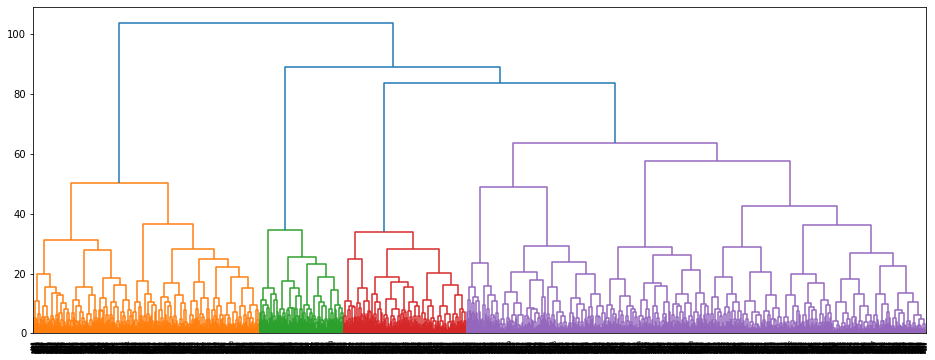

In [21]:
# Построим матрицу расстояний:
linked = linkage(x_sc, method = 'ward')
display(linked)

# Построим дендрограмму:
plt.figure(figsize=(16,6))
dendrogram(linked, orientation='top')
plt.show()

<div class="alert alert-info"> Вывод: На основании дендрограммы можно выделить 4 кластера клиентов.

#### Обучите модель кластеризации на основании алгоритма K-Means и спрогнозируйте кластеры клиентов. 

In [22]:
# Задаём модель k_means с числом кластеров 5:
km = KMeans(n_clusters = 5, random_state = 0)

# Прогнозируем кластеры клиентов:
labels = km.fit_predict(x_sc)

# Выделяем кластеры в отдельный столбец:
df['klasters'] = labels
display(df)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,klasters
0,1,1,1,1,0,6,1,29,14.23,5,3,0.02,0.00,0,2
1,0,1,0,0,1,12,1,31,113.20,12,7,1.92,1.91,0,3
2,0,1,1,0,1,1,0,28,129.45,1,2,1.86,1.74,0,1
3,0,1,1,1,1,12,1,33,62.67,12,2,3.21,3.36,0,3
4,1,1,1,1,1,1,0,26,198.36,1,3,1.11,1.12,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.41,12,8,2.28,2.35,0,3
3996,0,1,0,0,1,1,1,29,68.88,1,1,1.28,0.29,1,1
3997,1,1,1,1,1,12,0,28,78.25,11,2,2.79,2.83,0,3
3998,0,1,1,1,1,6,0,32,61.91,5,3,1.63,1.60,0,3


#### Посмотрим на средние значения признаков для кластеров.

In [23]:
# Вычисляем средние значения признаков по кластерам:
df_klaster_group = df.groupby('klasters').mean().reset_index()
display(df_klaster_group)

,klasters,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,0,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457267,2.198020,2.809901,1.660436,1.477030,0.443564
1,1,0.484512,1.000000,0.351072,0.237490,1.000000,1.954726,0.341541,28.165210,131.444162,1.862589,2.430500,1.246315,1.011136,0.515488
2,2,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957688,4.475325,3.924675,1.846909,1.716364,0.267532
3,3,0.503490,0.959123,0.782652,0.573280,1.000000,10.923230,0.546361,29.991027,160.881884,9.983051,4.748754,1.977617,1.970040,0.027916
4,4,0.560142,0.976415,0.359670,0.238208,0.998821,2.685142,0.469340,30.110849,161.665755,2.476415,4.889151,2.846580,2.845059,0.067217


<div class="alert alert-info"> Вывод:
Что особенно выделяется:

- У 3 кластера признаки - contract_period, month_to_end_contract  в 3-4 раза выше чем у остальных кластеров.

#### Построим распределения признаков для кластеров.

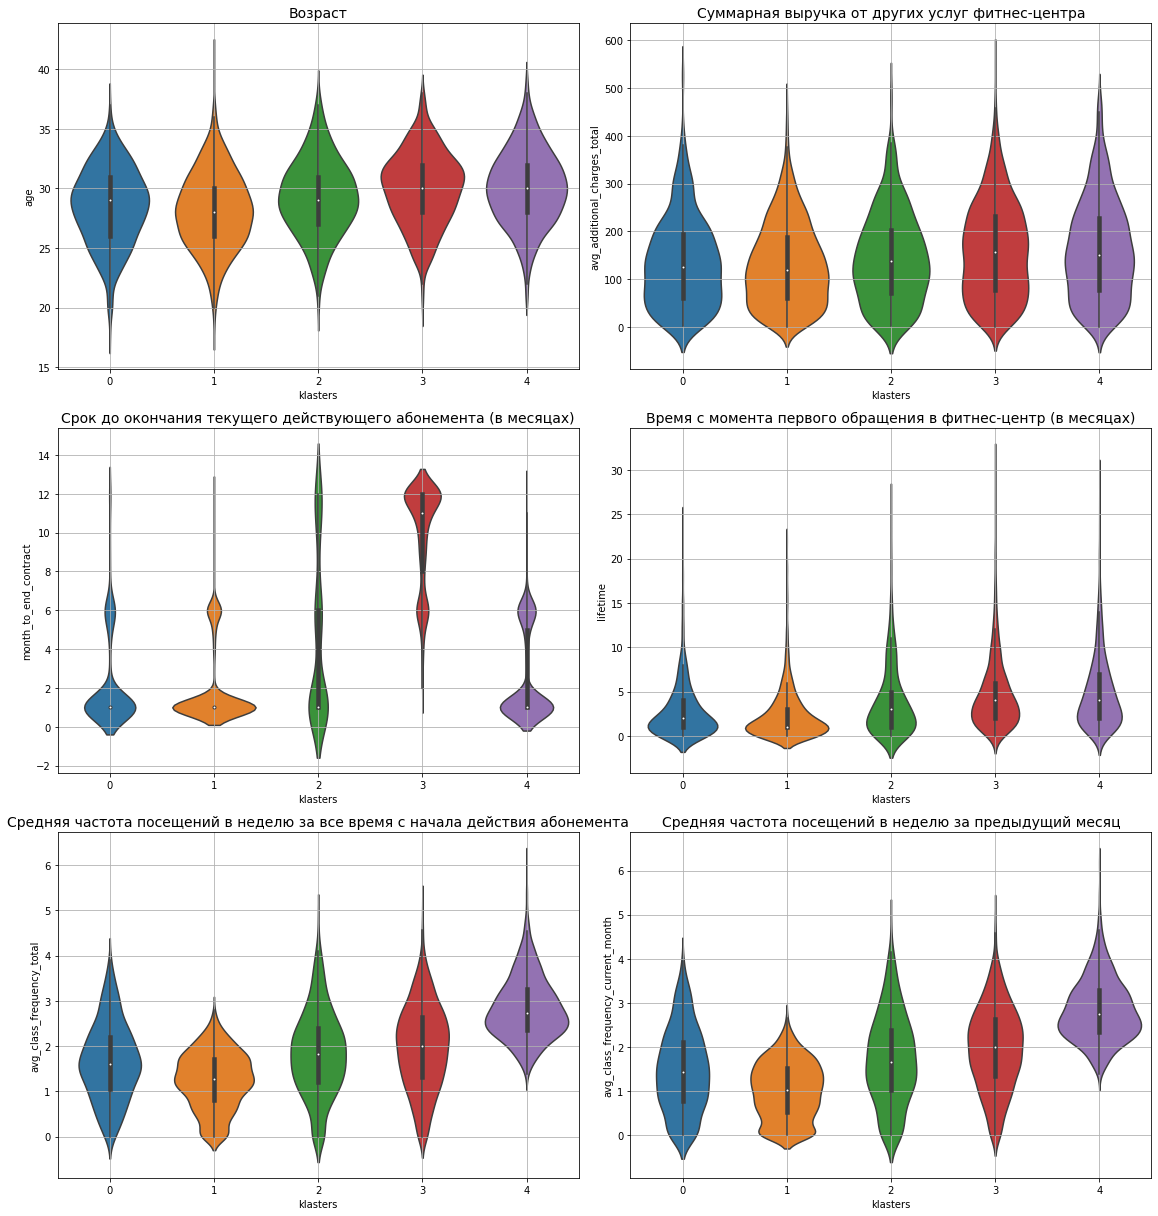

In [24]:
# Строим графики рапсределения признаков по кластерам:    
fig = plt.figure(figsize = (16,17), constrained_layout=False)
i = 1
for col, name in zip(colmns_cont['eng'], colmns_cont['rus']):
    ax = fig.add_subplot(3,2,i)
    ax=sns.violinplot(x='klasters', y=col, data=df)
     
    plt.title(name, fontsize=14)
    #plt.ylabel(col)
    plt.grid(True)
    i += 1
    fig.tight_layout()

<div class="alert alert-info"> Вывод по графикам violinplot: Так же заметно, что 3 кластер признак - month_to_end_contract значительно выше чем у остальных кластеров. Заметно увеличение значений признаков клиента таких как -  возраст клиентов, lifetime, средней частоты посещений в неделю с начала действия абонемента и за предыдущий месяц. 

<div class="alert alert-info"> Так же кластер 4 выделяется признаками - 'avg_class_frequency_total','avg_class_frequency_current_month',клиенты кластера, чаще остальных посещают фитнес центр. А кластер 1 по эти признакам имеет наименьшие значения среди других кластеров. Кластеры 0 и 2 весьма сходны, за исключением признака 'month_to_end_contract', у клиентов кластера 2 срок окончания абонемента в основном 1 мес. чего не скажешь о кластере 2 - клиенты которого имеют срок окончания абонемента и 6 и 12 мес.

### Добавим графики для дискретных переменных:

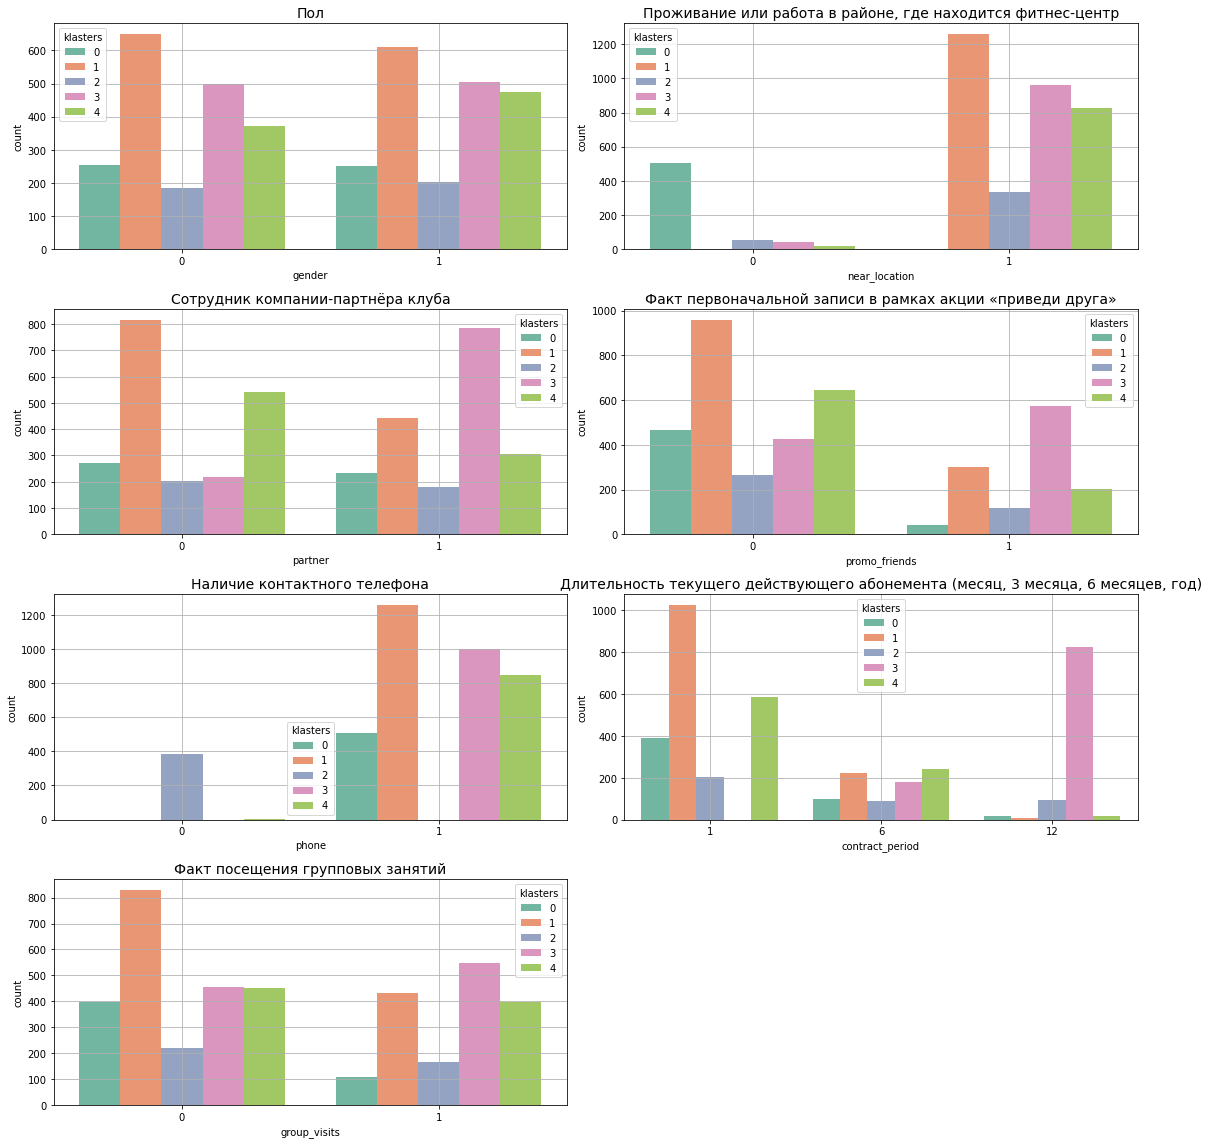

In [26]:
# Построим графики рапсределения признаков по кластерам для дискретных переменных: 
fig = plt.figure(figsize=(16,16))

i = 1
for col, name in zip(colmns_discr['eng'], colmns_discr['rus']):
    ax = fig.add_subplot(4,2,i)
    ax=sns.countplot(x=col, data=df, hue='klasters', palette="Set2")
        
    plt.title(name, fontsize=14)
    plt.grid(True)
    i += 1
    fig.tight_layout()

<div class="alert alert-info"> Вывод: На графиках видно, что равное распределение по признаку - пол. По признаку - проживание или работа в районе, где находится фитнес цент - кластер 0 характеризуется тем, что клинеты не проживают и не работают вблизи фитнес-центра в отличии от других. По признаку - сотрудник компании партнер клуба кластеры 0 и 1 разделились по ровну, кластеры 1 и 4 имею соотношение признака - 2 к 1, и 80% клиентов кластера 3 являются сотрудниками компании партнера. Большая часть клиентов пришла вне рамок акции - приведи друга, за исключением кластера 3, где приемрно 58% клиентов пришли по этой акции. Клиенты кластера 2 - не оставляют телефон. Наиболее встречающийся срок действия абонемента для кластера 3 - 12 мес, для кластера 0, 1, 2 и 4 - 1 мес. Групповые занятия посещают примерно четверть клиентов кластера 0, только треть клиентов кластера 1, 40% кластера 2, и половина клиентов кластеров 3 и 4.

#### Для каждого полученного кластера посчитаем долю оттока (методом groupby()). Выясним отличаются ли они по доле оттока и какие кластеры склонны к оттоку, а какие более - надёжны.

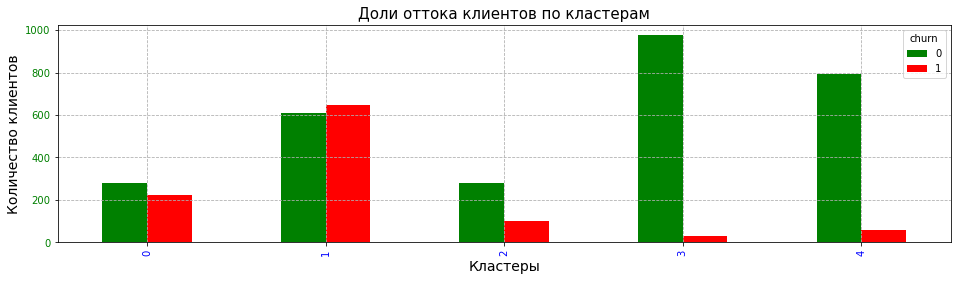

churn,klasters,0,1,%_0,%_оттока
0,0,281,224,55.6,44.4
1,1,610,649,48.5,51.5
2,2,282,103,73.2,26.8
3,3,975,28,97.2,2.8
4,4,791,57,93.3,6.7


In [27]:
# Сделаем сводную таблицу для граика:
klaster_churn = df.pivot_table(index='klasters', columns='churn' , values='age', aggfunc='count')
#display(klaster_churn)

# Построим график:
klaster_churn.plot.bar(figsize=(16,4), color=['green', 'red'])
plt.title("Доли оттока клиентов по кластерам", size=15)
plt.ylabel("Количество клиентов", size=14)
plt.yticks(color='green')
plt.xlabel("Кластеры", size=14)
plt.xticks(color='blue')
plt.grid(linestyle=( '--'))
plt.show()

# Вычислим процентное соотношение:
klaster_churn = klaster_churn.reset_index()
klaster_churn['%_0'] = round(klaster_churn[0] * 100 / (klaster_churn[0] + klaster_churn[1]),1)
klaster_churn['%_оттока'] = round(klaster_churn[1] * 100 / (klaster_churn[0] + klaster_churn[1]),1)
display(klaster_churn)

# С помощью groupby:
#klaster_group = df.groupby(['klasters','churn']).agg({'age':'count'}).reset_index()
#klaster_group = klaster_group.rename(columns=({'age':'count_churn'}))
#display(klaster_group)

In [28]:
# Выведем таблицу для поиска признаков, оказывающих наибольшее влияние на отток:
display(df_klaster_group.loc[df_klaster_group['klasters'].isin([0,1,2,3,4])])

,klasters,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,0,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457267,2.198020,2.809901,1.660436,1.477030,0.443564
1,1,0.484512,1.000000,0.351072,0.237490,1.000000,1.954726,0.341541,28.165210,131.444162,1.862589,2.430500,1.246315,1.011136,0.515488
2,2,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957688,4.475325,3.924675,1.846909,1.716364,0.267532
3,3,0.503490,0.959123,0.782652,0.573280,1.000000,10.923230,0.546361,29.991027,160.881884,9.983051,4.748754,1.977617,1.970040,0.027916
4,4,0.560142,0.976415,0.359670,0.238208,0.998821,2.685142,0.469340,30.110849,161.665755,2.476415,4.889151,2.846580,2.845059,0.067217


<div class="alert alert-info"> Вывод: кластеры 0 и 1, наиболее склонны к оттоку(44 и 51% клиентов кластеров попали в отток). Так же кластер 2 имеет долю оттока в 27%. Клиенты кластеров 3 и 4 практически не попадают в отток(всего 2.8 и 6.7% клиентов кластеров попали в отток)

## Выводы и базовые рекомендации по работе с клиентами.

<div class="alert alert-info"> Общий вывод:

Т.к. основная доля клиентов попавших в отток относится к кластеру 0, то на его основе перечислим признаки, которые наиболее этому способствовали. Стоит заметить кластер 0 имеет наиболее низкие средние значения по всем признакам. Отметим признаки, которые оказали наиболее существенное влияние на отток клиентов:
    
- near_location - наиболее низкое среднее значние.
- promo_friends
- contract_period
- month_to_end_contract
- lifetime

Исходя из этих признаков можно сделать следующие рекомендации:

- клиенты пришедшие по промокоду друга попадают в отток. Акция не очень эффективна.
- клиенты с невысоким сроком абонемента (1.2 и 1.5 месяца (среднее)) попадают в отток. Может стоит пересмотреть длительность абонементов.
- клиенты у которых срок до окончания текущего действующего абонемента составляет 1.1 и 1.4 мес, попадают в отток. Предлагать продлить абонемент за 1.5 месяца до окончания действия текущего абонемента.
- наиболее склонные к оттоку клиенты это клиенты которые пришли недавно от мес до 1.5. Нужно придумать как их удержать

<div class="alert alert-info"> Маркетинговые действия:
    
- Если посмотреть на средние значения признаков по кластерам, то фитнес центру нужны клиенты  кластеров 3 и 4 как наименее склонные к оттоку. Это клиенты, которые проживают или работаеют рядом, имеют длительный абонемент, и чаще всех посещают фитнес центр. По этому нужно сосредоточится на локальном привлечении клиентов(те кто рядом), привлекать больше предприятий партнеров, возможно предлагать групповые визиты, т.к ср значения признака для кластера тоже выше чем для других кластеров. И возможно увеличить длительность абонемента до 1,5 - 2 лет.